# Poisson equation

This demo illustrates how to:

- Create a `function space <dolfinx.fem.FunctionSpace>`
- Solve a linear partial differential equation

## Equation and problem definition

For a domain $\Omega \subset \mathbb{R}^n$ with boundary $\partial
\Omega = \Gamma_{D} \cup \Gamma_{N}$, the Poisson equation with
particular boundary conditions reads:

$$
\begin{align}
  - \Delta u &= f \quad {\rm in} \ \Omega, \\
  u &= 0 \quad {\rm on} \ \Gamma_{D}, \\
  \nabla u \cdot n &= g \quad {\rm on} \ \Gamma_{N}. \\
\end{align}
$$

where $f$ and $g$ are input data and $n$ denotes the outward directed
boundary normal. The variational problem reads: find $u \in V$ such
that

$$
a(u, v) = L(v) \quad \forall \ v \in V,
$$

where $V$ is a suitable function space and

$$
\begin{align}
  a(u, v) &:= \int_{\Omega} \nabla u \cdot \nabla v \, {\rm d} x, \\
  L(v)    &:= \int_{\Omega} f v \, {\rm d} x + \int_{\Gamma_{N}} g v \, {\rm d} s.
\end{align}
$$

The expression $a(u, v)$ is the bilinear form and $L(v)$
is the linear form. It is assumed that all functions in $V$
satisfy the Dirichlet boundary conditions ($u = 0 \ {\rm on} \
\Gamma_{D}$).

In this demo we consider:

- $\Omega = [0,2] \times [0,1]$ (a rectangle)
- $\Gamma_{D} = \{(0, y) \cup (2, y) \subset \partial \Omega\}$
- $\Gamma_{N} = \{(x, 0) \cup (x, 1) \subset \partial \Omega\}$
- $g = \sin(5x)$
- $f = 10\exp(-((x - 0.5)^2 + (y - 0.5)^2) / 0.02)$

## Implementation

The modules that will be used are imported:

In [37]:
from mpi4py import MPI
from petsc4py.PETSc import ScalarType

In [38]:
import numpy as np

import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner

from dolfinx.fem.petsc import assemble_matrix


Note that it is important to first `from mpi4py import MPI` to
ensure that MPI is correctly initialised.

We create a rectangular `Mesh <dolfinx.mesh.Mesh>` using
`create_rectangle <dolfinx.mesh.create_rectangle>`, and
create a finite element `function space
<dolfinx.fem.FunctionSpace>` $V$ on the mesh.

In [39]:
msh = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=((0., 0), (2.0, 1.0)),
    n=[20, 10],
    cell_type=mesh.CellType.quadrilateral,
)
V = fem.functionspace(msh, ("Lagrange", 3))

The second argument to `functionspace
<dolfinx.fem.functionspace>` is a tuple `(family, degree)`, where
`family` is the finite element family, and `degree` specifies the
polynomial degree. In this case `V` is a space of continuous Lagrange
finite elements of degree 1.

To apply the Dirichlet boundary conditions, we find the mesh facets
(entities of topological co-dimension 1) that lie on the boundary
$\Gamma_D$ using `locate_entities_boundary
<dolfinx.mesh.locate_entities_boundary>`. The function is provided
with a 'marker' function that returns `True` for points `x` on the
boundary and `False` otherwise.

In [40]:
def bound_f(x):
     # print(x[0])
     y = np.isclose(x[0], 0) | np.isclose(x[0], 2)
     # print(y)
     return y
facets = mesh.locate_entities_boundary(
    msh,
    dim=(msh.topology.dim - 1),
    marker=bound_f,
)


We now find the degrees-of-freedom that are associated with the
boundary facets using `locate_dofs_topological
<dolfinx.fem.locate_dofs_topological>`:

In [41]:
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

and use `dirichletbc <dolfinx.fem.dirichletbc>` to create a
`DirichletBC <dolfinx.fem.DirichletBC>` class that
represents the boundary condition:

In [42]:
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

Next, the variational problem is defined:

In [43]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)
g = ufl.sin(5 * x[0])
a = inner(grad(u), grad(v)) * dx
L = inner(f, v) * dx + inner(g, v) * ds

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


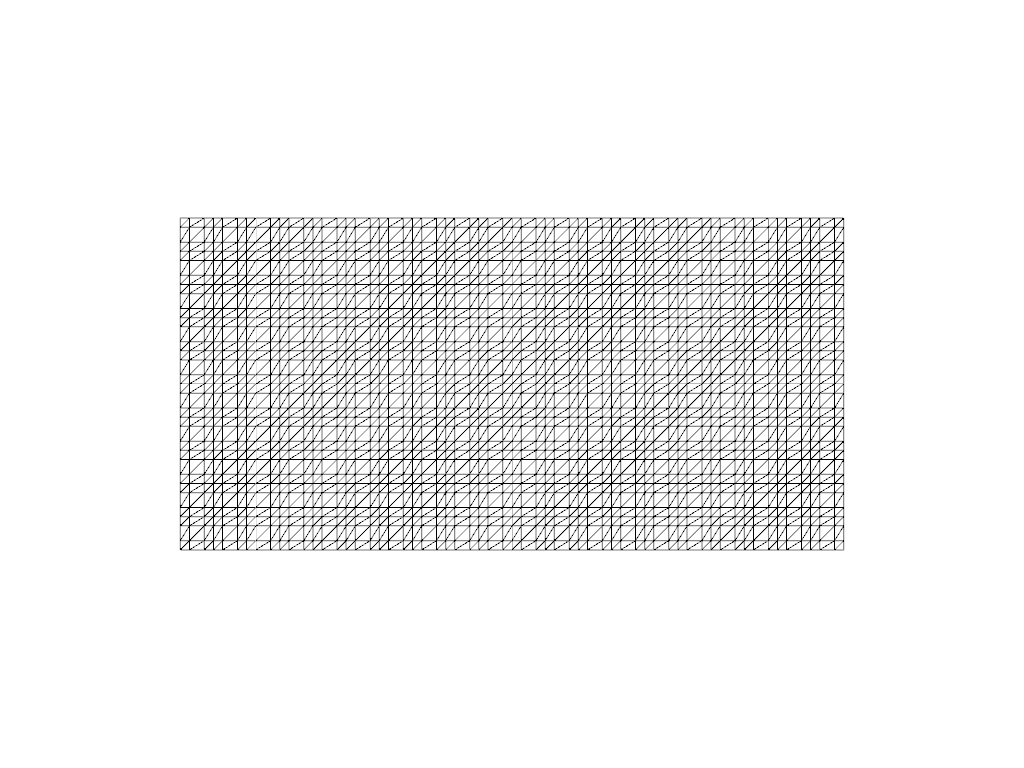

In [44]:
import pyvista 

# The following line is needed in linux/docker/binder, not on MacOS
pyvista.start_xvfb()
pyvista.set_jupyter_backend('static')


p = pyvista.Plotter()
topology, cell_types, dom_geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, dom_geometry)
p.add_mesh(grid, style="wireframe", color="k")
p.camera_position = 'xy'
p.show()
# p.screenshot("mesh-for-sparsity.png")


In [45]:
# A = assemble_matrix(fem.form(a), bcs=[bc])
# A.assemble()

# nnz = A.getInfo()['nz_used']
# shape = A.getLocalSize()

# print(f"Dimensions of the matrix A: {shape}")
# print(f"Number of nonzero elements of A: {nnz}")
# print(f"Nonzero/dofs: {nnz/shape[0]}")

# r, c, v = A.getValuesCSR()
# from scipy.sparse import csr_matrix
# A_sp = csr_matrix((v, c, r), A.getLocalSize())
# import matplotlib.pyplot as plt
# plt.spy(A_sp)
# plt.savefig("sparsity.png")


In [46]:
# print(A_sp.todense())


A `LinearProblem <dolfinx.fem.petsc.LinearProblem>` object is
created that brings together the variational problem, the Dirichlet
boundary condition, and which specifies the linear solver. In this
case an LU solver is used. The `solve
<dolfinx.fem.petsc.LinearProblem.solve>` computes the solution.

In [47]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

uh = problem.solve()

The solution can be written to a `XDMFFile
<dolfinx.io.XDMFFile>` file visualization with ParaView or VisIt:

In [48]:
with io.VTKFile(msh.comm, "out_poisson/poisson.vtk", "w") as file:
    file.write_mesh(msh)
    file.write_function(uh)

and displayed using [pyvista](https://docs.pyvista.org/).

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


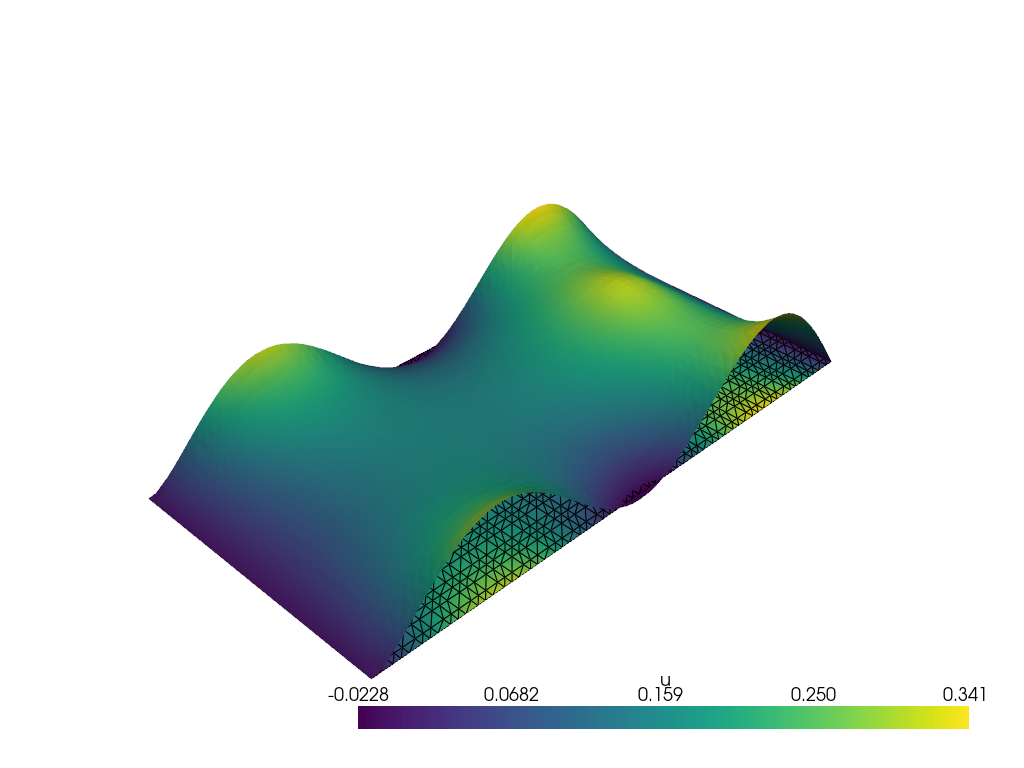

In [49]:
import pyvista

# pyvista.set_jupyter_backend('html')

cells, types, x = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
plotter.screenshot("uh_poisson.png")

if pyvista.OFF_SCREEN:
    pyvista.start_xvfb(wait=0.1)
    # plotter.screenshot("uh_poisson.png")
else:
    plotter.show()
    # plotter.screenshot("uh_poisson.png")
